In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import nbimporter
from feature_functions import *
from collections import deque
from alpha_vantage.timeseries import TimeSeries
%matplotlib inline

Importing Jupyter notebook from feature_functions.ipynb


In [2]:
from alpha_vantage.timeseries import TimeSeries

In [3]:
cle_api = 'JBQR4M9YCQRT0EWV'

In [4]:
ts= TimeSeries(key=cle_api, output_format='pandas')

In [5]:
data,meta_data=ts.get_intraday(symbol='EURUSD',interval='60min',outputsize='full')

In [6]:
data.loc[::-1,].to_excel("Bases de Donnees/Base_Courante.xlsx")

In [7]:
data.loc[::-1,].tail

<bound method NDFrame.tail of                      1. open  2. high  3. low  4. close  5. volume
date                                                              
2020-07-26 19:00:00   1.1653   1.1656  1.1641    1.1649        0.0
2020-07-26 20:00:00   1.1650   1.1699  1.1648    1.1689        0.0
2020-07-26 21:00:00   1.1688   1.1699  1.1684    1.1692        0.0
2020-07-26 22:00:00   1.1692   1.1716  1.1688    1.1710        0.0
2020-07-26 23:00:00   1.1710   1.1725  1.1706    1.1711        0.0
...                      ...      ...     ...       ...        ...
2020-08-27 08:00:00   1.1813   1.1839  1.1798    1.1833        0.0
2020-08-27 09:00:00   1.1833   1.1902  1.1786    1.1804        0.0
2020-08-27 10:00:00   1.1804   1.1810  1.1761    1.1786        0.0
2020-08-27 11:00:00   1.1788   1.1830  1.1778    1.1823        0.0
2020-08-27 12:00:00   1.1823   1.1833  1.1816    1.1827        0.0

[566 rows x 5 columns]>

In [8]:
def data_prep(data):
    Data = data.copy()
    Data =  Data.loc[::-1,]

    Data.columns = ['open','high','low','close','volume']

    Data.drop(columns='volume',inplace=True)

    Data.head()

    Base = heikenashi(Data,[1])


    Base.columns=['open','high','low','close']
    Base.head()

    res = momentum(Base,[10]).close[10]
    Base=Base.loc[Base.index[10]:]
    Base['momentum'] = res

    Base['return'] = Base['close'] - Base['close'].shift(1)

    Base['label'] = Base['return'].shift(-1)
    Base['label'] = Base['label'].apply(lambda x: 1 if x>0.0 else 0)
    Base.dropna(inplace=True)

    Base.dropna(inplace=True)

    DF = Base.loc[:,['momentum','return','label']]
    DF.dropna(inplace=True)
    return(DF)

In [9]:
DF = data_prep(data)

In [10]:
DF_Norm = DF.copy()

In [11]:
def normalisation(data):
    momentum_ecartype =data['momentum'].std()
    momentum_mean =data['momentum'].mean()
    return_ecartype =data['return'].std()
    return_mean = data['return'].mean()
    data.loc[:,'momentum'] = data['momentum'] - momentum_mean
    data.loc[:,'momentum'] = data['momentum']/momentum_ecartype
    data.loc[:,'return'] = data['return'] - return_mean
    data.loc[:,'return'] = data['return']/return_ecartype

In [12]:
normalisation(DF_Norm)

In [13]:
n_features =60

In [14]:
def sequencement(data,memoire):
    sequences = []
    prev_hours = deque(maxlen=memoire)
    for observation in data.values:
        prev_hours.append([x for x in observation[:-1]])  
        if len(prev_hours) == memoire:
            sequences.append([np.array(prev_hours), observation[-1]])    
    return sequences

In [15]:
sequences = sequencement(DF_Norm,n_features)

In [16]:
def prep_prediction(sequences):
    X= np.array([exemple[0] for exemple in sequences])
    Y= np.array([int(exemple[1]) for exemple in sequences])
    
    Y.shape = (Y.shape[0],1)
    Y= [int(x) for x in Y]
    return X,Y

In [17]:
x_to_pred,y_data = prep_prediction(sequences)

In [18]:
def prediction(x_to_predict,model):
    predicted_y = ([x[1] for x in np.round(model.predict(x_to_predict))])
    return(predicted_y)

In [19]:
modele = tf.keras.models.load_model('Modeles/RNN')

In [20]:
x_to_pred

array([[[ 1.20869535,  2.25882881],
        [ 1.11754195,  1.84856467],
        [ 1.15961275,  1.40899595],
        ...,
        [ 0.61970415, -0.75954307],
        [ 0.99834135,  1.46760511],
        [ 1.51020275,  0.50055393]],

       [[ 1.11754195,  1.84856467],
        [ 1.15961275,  1.40899595],
        [ 0.86511715,  0.09028979],
        ...,
        [ 0.99834135,  1.46760511],
        [ 1.51020275,  0.50055393],
        [ 1.58733255,  0.09028979]],

       [[ 1.15961275,  1.40899595],
        [ 0.86511715,  0.09028979],
        [ 1.57330895,  2.20021965],
        ...,
        [ 1.51020275,  0.50055393],
        [ 1.58733255,  0.09028979],
        [ 0.90017615, -0.67162932]],

       ...,

       [[ 0.10784275,  0.03168063],
        [ 0.32520855,  0.44194477],
        [ 0.46544455, -0.05623312],
        ...,
        [-0.27780625,  1.55551886],
        [-0.01135785,  1.20386388],
        [-1.25244646, -4.83287987]],

       [[ 0.32520855,  0.44194477],
        [ 0.46544455, -0.05

In [21]:
y_predicted = prediction(x_to_pred,modele)

In [22]:
score = modele.evaluate(x_to_pred, np.array(y_data), verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.57459676


In [28]:
def calc_profit(row,contracts,commission=0):
    if row['won']:
        return abs(row['return'])*contracts - 8*contracts/100000
    else:
        return -abs(row['return'])*contracts - 8*contracts/100000

def backtest(data,predicted_y,y_data,memoire,contracts=2000,retour=False,plot=True):
    df_trade = pd.DataFrame(np.array(data['return'][n_features-1:]), columns=['return'])
    df_trade['label']  = y_data
    df_trade['pred']   = predicted_y
    df_trade['won']    = df_trade['label'] == df_trade['pred']
    df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

    df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row,contracts), axis=1)
    df_trade['equity'] = df_trade['pnl'].cumsum()
    if(plot):
        df_trade.plot(y='equity', figsize=(20,8), title=f'Backtest : {int(contracts)}$ par Transaction')
        plt.xlabel('Nombre de Trades')
        plt.ylabel('Profit (USD)')
        for r in df_trade.iterrows():
            if r[1]['won']:
                plt.axvline(x=r[0], linewidth=1, alpha=0.8, color='g')
            else:
                plt.axvline(x=r[0], linewidth=1, alpha=0.8, color='r')
    if(retour):
        return(df_trade)


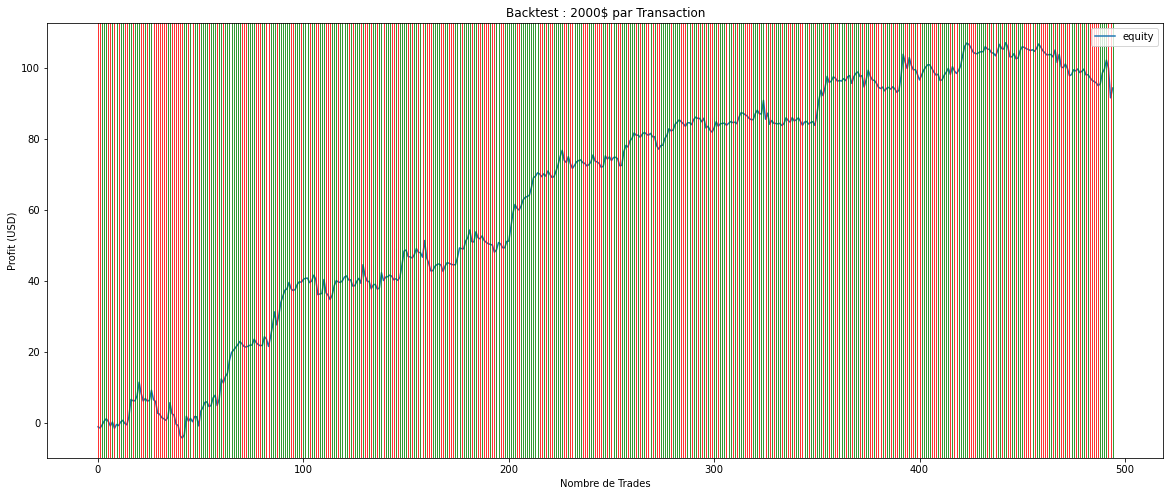

In [29]:
backtest(DF,y_predicted,y_data,n_features,2000)

In [30]:
def resume(df_trade):
    n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
    n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
    print("Profit Net : $%.2f" % df_trade.tail(1)['equity'])
    print("Nombre de prédictions justes : %d" % n_win_trades)
    print("Number de prédictions fausses  : %d" % n_los_trades)
    print("Précision    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
    print("Moyenne par Transaction Gagnée : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
    print("Moyenne par Transaction Perdue  : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
    print("Gain le plus important   : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
    print("Perte la plus importante  : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())

    df_trade['pnl'].hist(bins=20)

Profit Net : $94.25
Nombre de prédictions justes : 260
Number de prédictions fausses  : 235
Précision    : 52.53%
Moyenne par Transaction Gagnée : $1.338
Moyenne par Transaction Perdue  : $-1.080
Gain le plus important   : $6.090
Perte la plus importante  : $-8.360


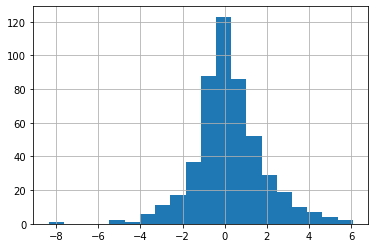

In [31]:
resume(backtest(DF,y_predicted,y_data,n_features,2000,plot=False,retour=True))